# DTSA 5509 Final Project
Author: Tyler B.

2022 Fall 2 Semester

## Project Description
For my project, I chose to use a datasource that I found on kaggle to try and predict heart failure. The practical goals of this are clear. If existing and available data can be used to predict the likely of heart failure, then preventative treatment can begin sooner and lives can potentially be saved. 

This problem is a supervised, binary classification problem. It is supervised since the data is labeled and binary classification since I will be trying to predict whether or not a patient has heart failure. 

Additionally, this project is a great chance for me to get additional practice and to continue growing as a Data Scientist. It is my hope that this project would cement the supervised machine learning skills that I have learned in this course.


## Data Description
Source: https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction?select=heart.csv

This datasource is a publicly available dataset that combines independent data collected from Cleveland, Hungarian, Switzerland, Long Beach, and Stalog hospitals. 

It contains 11 features and 918 observations, making it one of the largest publicly available cardiovascular datasets. A description of each feature can be seen below.


    Age: age of the patient [years]
    Sex: sex of the patient [M: Male, F: Female]
    ChestPainType: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
    RestingBP: resting blood pressure [mm Hg]
    Cholesterol: serum cholesterol [mm/dl]
    FastingBS: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
    RestingECG: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
    MaxHR: maximum heart rate achieved [Numeric value between 60 and 202]
    ExerciseAngina: exercise-induced angina [Y: Yes, N: No]
    Oldpeak: oldpeak = ST [Numeric value measured in depression]
    ST_Slope: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
    HeartDisease: output class [1: heart disease, 0: Normal]


## Data Cleaning and Exploratory Data Analysis (EDA)
First, I will load in the necessary packages for this project.

In [309]:
# Load in necessary packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
%matplotlib inline

Next, I will set the random seed that will be used throughout the code. This is very important to ensure that all of my results and conclusions are repeatable.

In [310]:
# Set random seed
seed = 22

Now, I will load in the data csv from the aforementioned kaggle website and will output some summary info from the data.

In [311]:
# Load in data for project
df = pd.read_csv("heart.csv")
print(df.head())

   Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140          289          0     Normal    172   
1   49   F           NAP        160          180          0     Normal    156   
2   37   M           ATA        130          283          0         ST     98   
3   48   F           ASY        138          214          0     Normal    108   
4   54   M           NAP        150          195          0     Normal    122   

  ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0              N      0.0       Up             0  
1              N      1.0     Flat             1  
2              N      0.0       Up             0  
3              Y      1.5     Flat             1  
4              N      0.0       Up             0  


In [312]:
# Print different summary things
print(df.shape) # for dimensions of dataframe
print(df.info()) # shows datatypes and non null counts
print(df.describe()) # gives summary stats for numeric values

(918, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB
None
              Age   RestingBP  Cholesterol   FastingBS       MaxHR  \
count  918.000000  918.000000   918.000000  918.000000  918.000000   
mean    53.510893  132.396514   198.799564    0

### Data Cleaning
We can see from the output above that the data contains 918 observations and 12 columns. This aligns with the data description (11 features + 1 response). We can also see that thare are no null values in this dataset. 

Looking at the df.describe() call, I notice some interesting results. Specifically, RestingBP and Cholesterol both have mins of 0.0. This does not make any sense as it is impossible to have a RestingBP or Cholesterol of 0. These values must signify null values. As a result, I will clean the data by removing the rows where either of these values is null.

In [313]:
# Need to remove outliers where resting bp, Cholesterol = 0 since that is not 
# possible and clearly indicates an error in the data
df = df.loc[df['RestingBP'] != 0.0,]
df = df.loc[df['Cholesterol'] != 0.0,]
df.shape

(746, 12)

After cleaning the data, I am left with 746 rows. This means that there were 918-746=172 rows where one of these values was 0. 

### Data Munging
Now that the data is clean, I will munge the data into the appropiate data types. The results from the above info call show that there are 5 categorical features that are 'object' datatypes. These will need to be encoded as integers for our models to work best. To start, I will print the unique values for each categorical value, just to get an idea of how many levels there are for each of the features.

In [314]:
# Show different values for each categorical variable
print(df['Sex'].unique()) 
print(df['ChestPainType'].unique()) 
print(df['RestingECG'].unique()) 
print(df['ExerciseAngina'].unique()) 
print(df['ST_Slope'].unique()) 

['M' 'F']
['ATA' 'NAP' 'ASY' 'TA']
['Normal' 'ST' 'LVH']
['N' 'Y']
['Up' 'Flat' 'Down']


Each of the categorical variables has a relatively limited number of levels. Thus, they can simply be encoded as integers and added back to the dataframe. The code below accomplishes this and shows the results from the updated describe call.

In [315]:
# Need to encode categorical data, this is type of data munging
cat_cols = list(df.select_dtypes(['object']).columns.values)
cat_df = df[cat_cols].apply(lambda x: x.astype('category').cat.codes)
df = df.drop(cat_cols, axis=1)
df = df.join(cat_df)
print(df.describe())

              Age   RestingBP  Cholesterol   FastingBS       MaxHR  \
count  746.000000  746.000000   746.000000  746.000000  746.000000   
mean    52.882038  133.022788   244.635389    0.167560  140.226542   
std      9.505888   17.282750    59.153524    0.373726   24.524107   
min     28.000000   92.000000    85.000000    0.000000   69.000000   
25%     46.000000  120.000000   207.250000    0.000000  122.000000   
50%     54.000000  130.000000   237.000000    0.000000  140.000000   
75%     59.000000  140.000000   275.000000    0.000000  160.000000   
max     77.000000  200.000000   603.000000    1.000000  202.000000   

          Oldpeak  HeartDisease         Sex  ChestPainType  RestingECG  \
count  746.000000    746.000000  746.000000     746.000000  746.000000   
mean     0.901609      0.477212    0.756032       0.840483    0.931635   
std      1.072861      0.499816    0.429762       0.958198    0.631939   
min     -0.100000      0.000000    0.000000       0.000000    0.000000   

### Exploratory Data Analysis (EDA)

Now that our data is cleaned and munged, I am ready to begin with some EDA. To start off with, I will look at a pairplot with kde's in the diaganol to get an idea of the pairwise relationships present in the data. 


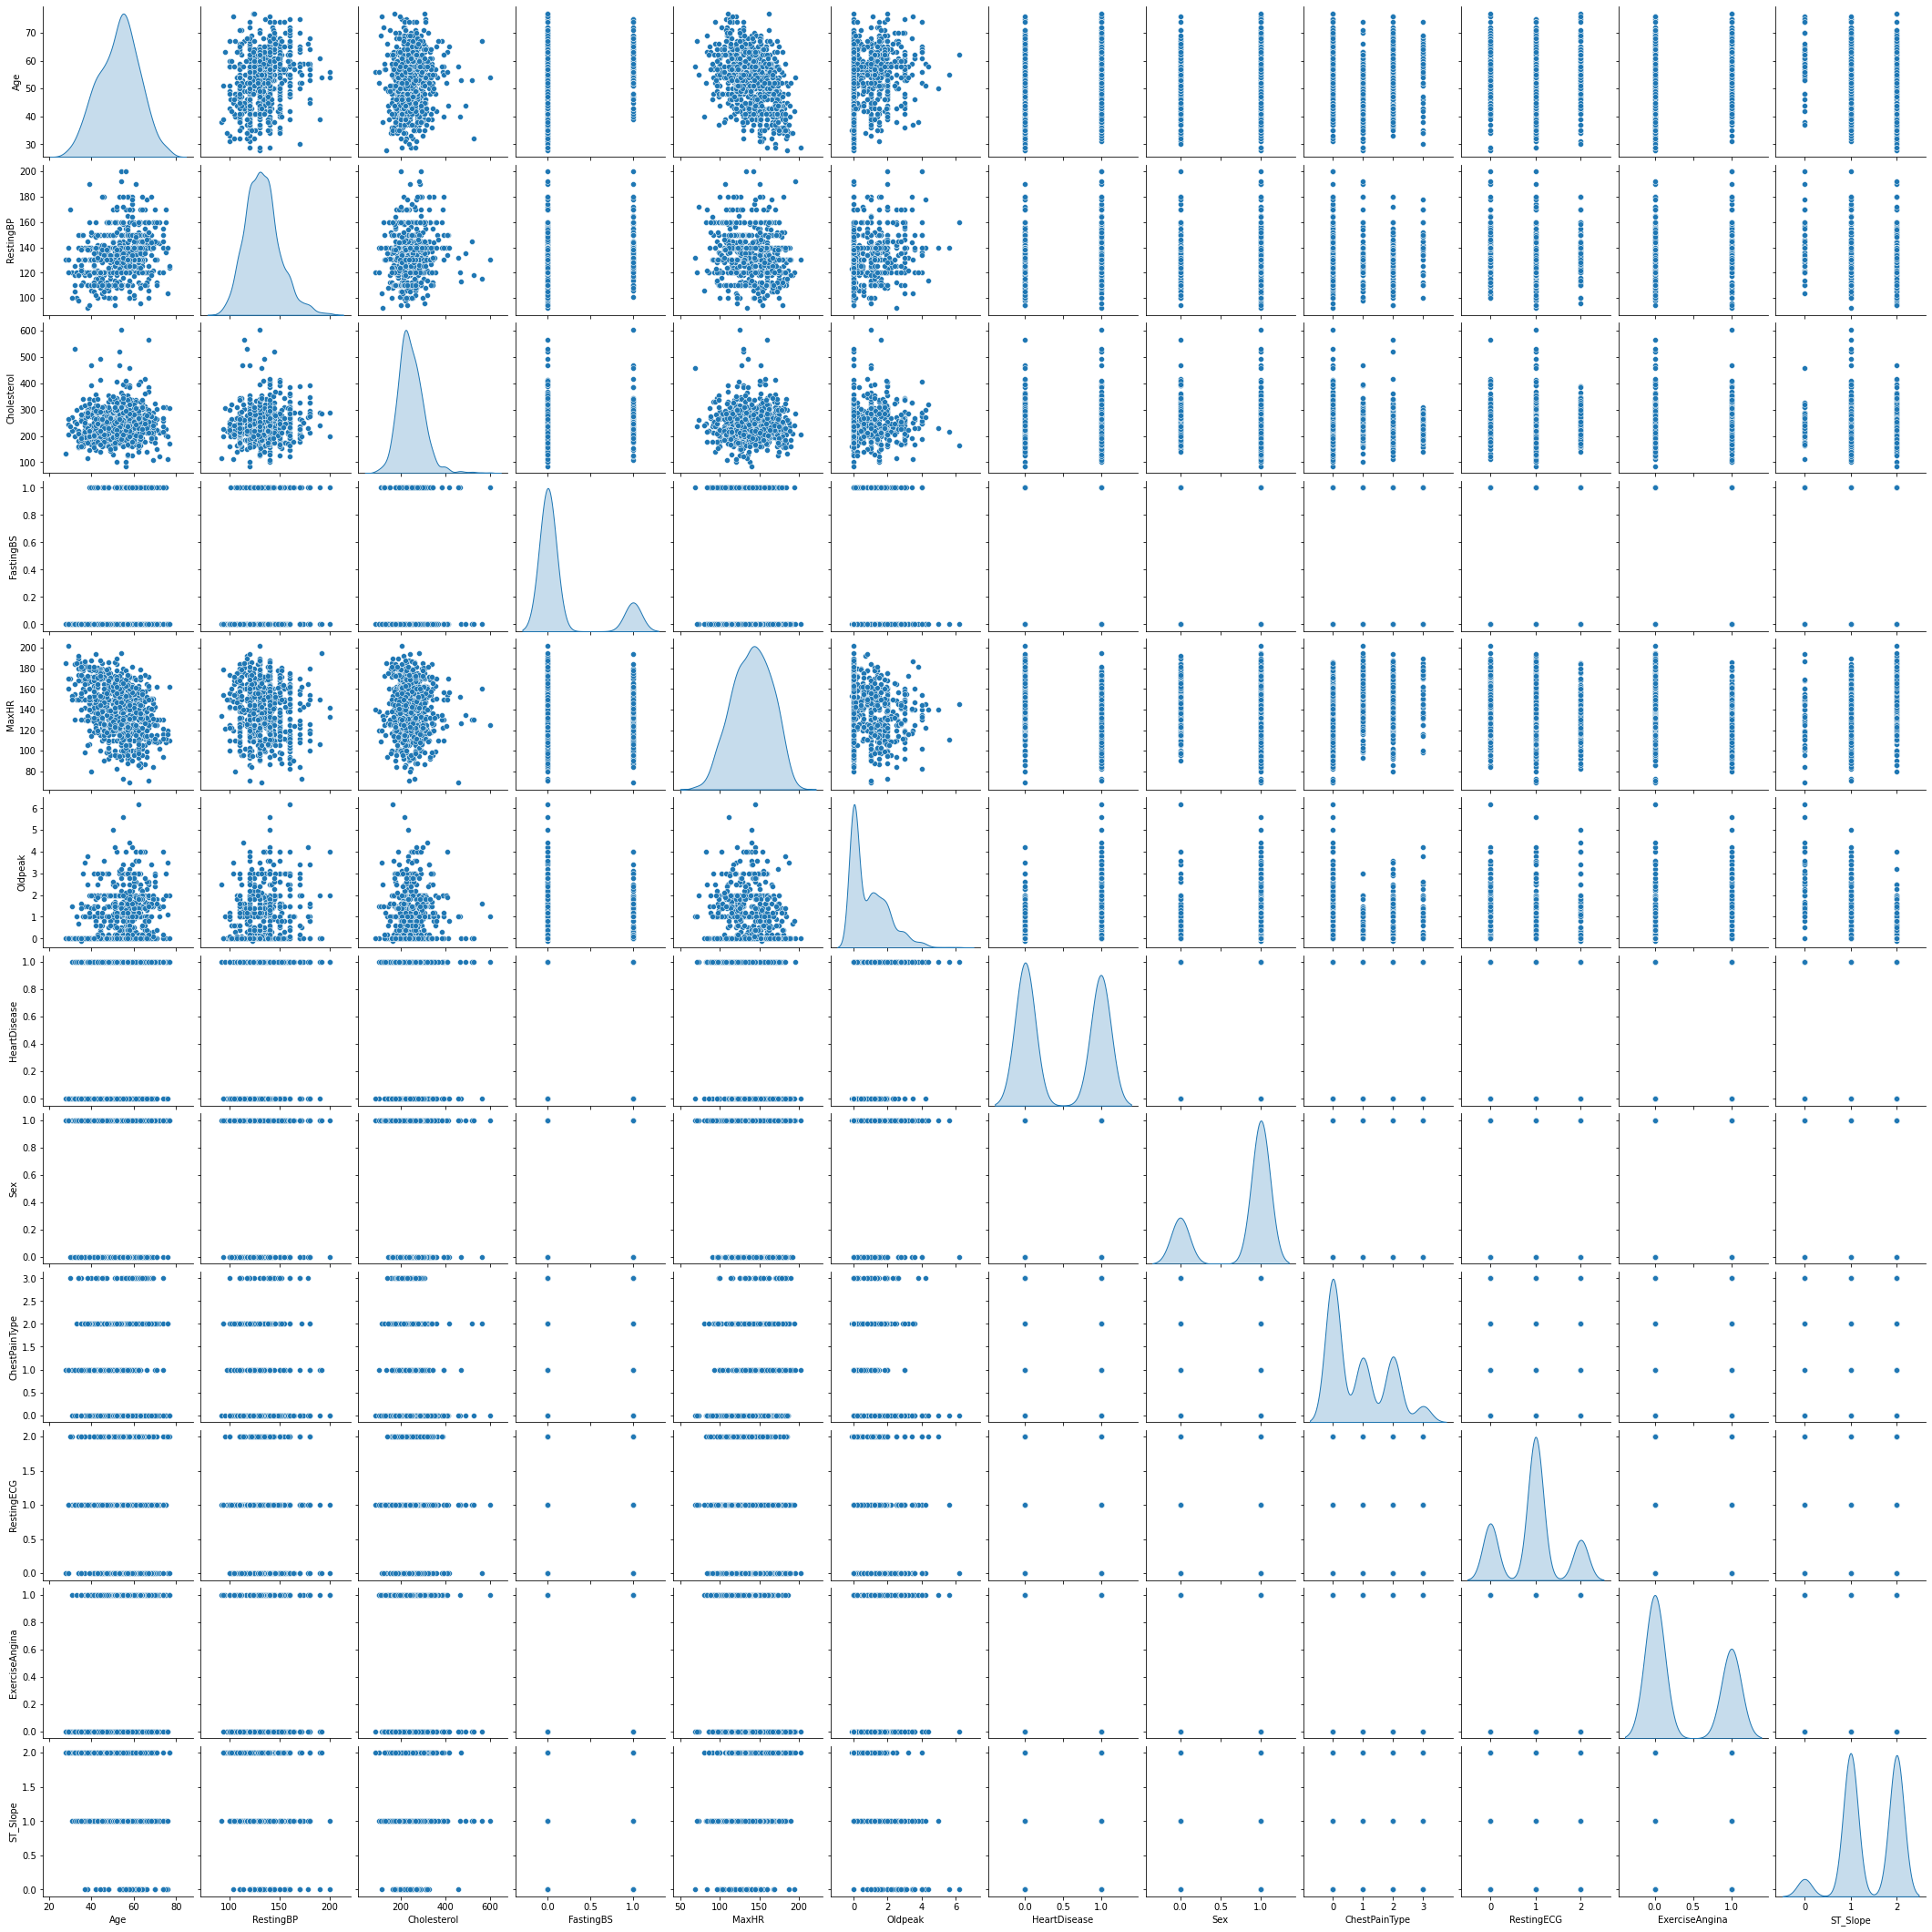

In [316]:
# Show pair plot
print(sns.pairplot(df, diag_kind='kde'))

Not much can be gathered from the pairwise plots seen here. However, one that this is really interesting is the kde plots on the diagonal.

These kde plots show us the following for each of the variables. 


*   Age: Looks to be normally distributed
*   RestingBP: Looks to be normally distributed
*   Cholesterol: Looks to be normally distributed
*   FastingBS: The vast majority of observations do not have fasting blood sugar (value of 0)
*   MaxHR: Appears to be normally distributed
*   Oldpeak: appears to be very heavily weighted to the left and not normally distributed
*   Sex: We can see that the majority of our records are female
*   ChestPainType: The ATA chest pain type is the most common in our records
*   RestingECG: ST resting ECG is the most common in our records
*   ExerciseAngina: The majority of our records have no exericise angina
*   ST_Slope: Up ST slopes seem to be very uncommon while the other two categories are pretty even. 

Lastly, this plot shows us that our response looks to be pretty well balanced, which is good news for us as it makes our analysis simpler. 

Next, I will look at a correlation matrix and a heat map, which should show similar results.



In [317]:
# Show correlation matrix
df.corr()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex,ChestPainType,RestingECG,ExerciseAngina,ST_Slope
Age,1.000000,0.259865,0.058758,0.241338,-0.382112,0.286006,0.298617,0.040917,-0.083120,-0.055419,0.245908,-0.285421
RestingBP,0.259865,1.000000,0.095939,0.173765,-0.125774,0.198575,0.173242,0.034363,-0.034066,0.035661,0.161035,-0.143881
Cholesterol,0.058758,0.095939,1.000000,0.054012,-0.019856,0.058488,0.103866,-0.107045,-0.102644,-0.070544,0.086768,-0.078516
FastingBS,0.241338,0.173765,0.054012,1.000000,-0.102710,0.055568,0.160594,0.096075,-0.000226,0.031518,0.109995,-0.157780
MaxHR,-0.382112,-0.125774,-0.019856,-0.102710,1.000000,-0.259533,-0.377212,-0.157002,0.303938,-0.158797,-0.396289,0.349926
Oldpeak,0.286006,0.198575,0.058488,0.055568,-0.259533,1.000000,0.495696,0.125743,-0.219761,-0.027555,0.465491,-0.613961
HeartDisease,0.298617,0.173242,0.103866,0.160594,-0.377212,0.495696,1.000000,0.292779,-0.395776,0.009935,0.551834,-0.597334
Sex,0.040917,0.034363,-0.107045,0.096075,-0.157002,0.125743,0.292779,1.000000,-0.120709,0.042296,0.192579,-0.142808
ChestPainType,-0.083120,-0.034066,-0.102644,-0.000226,0.303938,-0.219761,-0.395776,-0.120709,1.000000,-0.046851,-0.394822,0.238469
RestingECG,-0.055419,0.035661,-0.070544,0.031518,-0.158797,-0.027555,0.009935,0.042296,-0.046851,1.000000,0.085602,0.017472


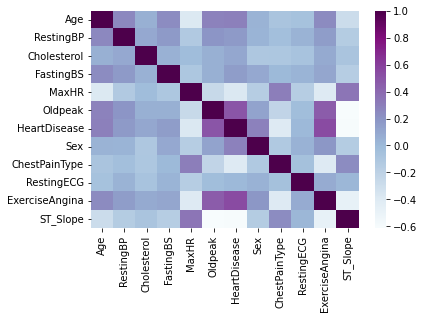

In [318]:
# Show heatmap
sns.heatmap(df.corr(), cmap="BuPu", yticklabels=True)

The correlation and heatmap show us what features are most correlated with our response. We can see here that Oldpeak and ExerciseAngina seem to be most correlated with the presence of heart disease. This is an early indicator that these two features could be very important for our binary classification task.

This heatmap / correlation matrix also shows us any correlations between features. The largest correlation among features appears to be ~-0.61. This is not too high as to indicate multicollinearity. In general, a correlation of 0.7 is cause for alarm when it comes to multicollinearity. Thus, we can safely move forward with our work without having to worry about multicollinearity.

Next, the code below creates boxplots for the continuous features and the response. This could be a good indicator of relationships between features and the response.

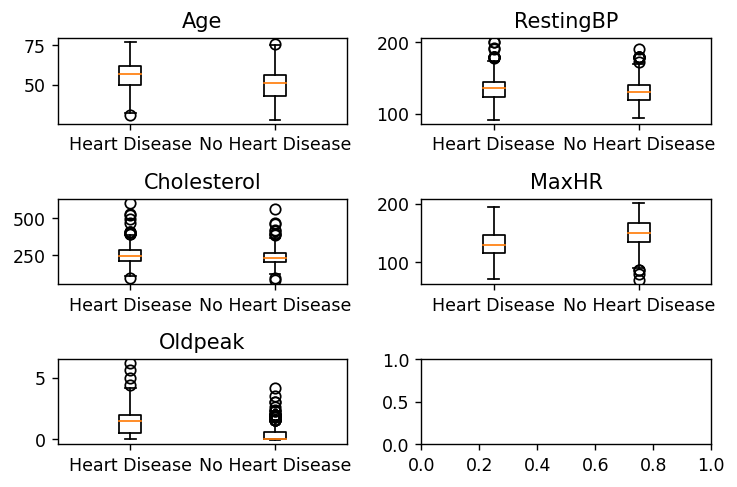

In [319]:
# Create boxplots of continuous features and response
df_hd = df.loc[df['HeartDisease'] == 1,]
df_no_hd = df.loc[df['HeartDisease'] == 0,]
labels = ['Heart Disease', 'No Heart Disease']

fig, ax = plt.subplots(nrows = 3, ncols = 2)

age_label = 'Age'
age = np.array([df_hd[age_label], df_no_hd[age_label]], dtype='object')
ax[0][0].boxplot(age, labels=labels)
ax[0][0].set_title(age_label)

rbp_label = 'RestingBP'
rbp = np.array([df_hd[rbp_label], df_no_hd[rbp_label]], dtype='object')
ax[0][1].boxplot(rbp, labels=labels)
ax[0][1].set_title(rbp_label)

c_label = 'Cholesterol'
c = np.array([df_hd[c_label], df_no_hd[c_label]], dtype='object')
ax[1][0].boxplot(c, labels=labels)
ax[1][0].set_title(c_label)

maxHR_label = 'MaxHR'
maxHR = np.array([df_hd[maxHR_label], df_no_hd[maxHR_label]], dtype='object')
ax[1][1].boxplot(maxHR, labels=labels)
ax[1][1].set_title(maxHR_label)

oldpeak_label = 'Oldpeak'
oldpeak = np.array([df_hd[oldpeak_label], df_no_hd[oldpeak_label]], dtype='object')
ax[2][0].boxplot(oldpeak, labels=labels)
ax[2][0].set_title(oldpeak_label)

fig.set_dpi(125)
fig.tight_layout()

We can see from the plot that Oldpeak, Age, and MaxHR seem to have noticable relationships with the presence of heart disease. 

Oldpeak aligns with the results found in the correlation matrix/heatmap and this is another indicator that Oldpeak could be an important feature.

Lastly, we will manually check the class balance of our response.

In [320]:
pd.value_counts(df['HeartDisease'], normalize = True)

0    0.522788
1    0.477212
Name: HeartDisease, dtype: float64

We can see here that our intuition from the pair plot is correct. Our data is pretty fairly balanced. Thus, we do not have to worry about implementing a class-imbalance solution (like oversampling or undersampling). This also means that our accuracy metric will be useful to us. Now we will experiment with different models

## Experimenting with Models and Results / Analysis

Now that our data has been cleaned and munged, and we have conducted our EDA, we are ready to begin testing different models. 

Since this is a supervised binary classification task, we have many models available to us. For this purpose of this analysis, I will look at Logistic Regression models, Random Forests, AdaBoost models, and Support Vector Machines (SVMs). I have chosen these 4 models since they all work with binary classification tasks and each one has different strengths and weaknesses. Comparing the 4 models will let us choose the one that fits our data best.

### Logistic Regression
First, we will look at Logistic Regression models. Logistic Regression does care about multicollinearity, however, we already confirmed that there is no multicollinearity in our model. 

To find the best Logistic Regression model for our data, we will conduct a grid search varying the C and solver hyperparameters.

In [321]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['HeartDisease'],axis=1), df['HeartDisease'], test_size=0.2, random_state=seed)

In [322]:
# Test Logistic Regression Model using grid search
param_grid = {
    'C': [0.01, 0.1, 1.0, 2.0, 10.0, 25.0, 50.0],
    'solver':['liblinear', 'sag', 'saga', 'newton-cg']
}

lr_gridsearch = GridSearchCV(LogisticRegression(random_state=seed, max_iter=10000), 
                          param_grid=param_grid, 
                          scoring='accuracy', cv=3, 
                          return_train_score=True, verbose=1)
lr_gridsearch.fit(X_train, y_train)

Fitting 3 folds for each of 28 candidates, totalling 84 fits


GridSearchCV(cv=3,
             estimator=LogisticRegression(max_iter=10000, random_state=22),
             param_grid={'C': [0.01, 0.1, 1.0, 2.0, 10.0, 25.0, 50.0],
                         'solver': ['liblinear', 'sag', 'saga', 'newton-cg']},
             return_train_score=True, scoring='accuracy', verbose=1)

In [323]:
print('Logistic Regression Results')
print('Best Model from Grid Search = {}'.format(lr_gridsearch.best_params_))
print('Best CV Score = {}'.format(lr_gridsearch.best_score_))
print('Test Accuracy from Best Model = {}'.format(lr_gridsearch.best_estimator_.score(X_test, y_test)))

y_pred = lr_gridsearch.best_estimator_.predict(X_test)
print('F1 Score from Best Model = {}'.format(f1_score(y_test, y_pred)))

Logistic Regression Results
Best Model from Grid Search = {'C': 10.0, 'solver': 'liblinear'}
Best CV Score = 0.8658105341522427
Test Accuracy from Best Model = 0.7933333333333333
F1 Score from Best Model = 0.794701986754967


We can see from the above output that the best Logistic Regression Model used C = 10 and a liblinear solver. It also obtained 86.6% CV accuracy and 79.3% accuracy and F1 score on the test data.  

### Random Forest
Next, we will look at Random Forest models. Unlike Logistic Regression, Random Forests are ensembled models. These collections of decision trees can have very nice results!

To find the best Random Forest model for our data, we will conduct a grid search varying the number of trees, max depth of each tree, and max number of features for each tree.

In [324]:
# Test Random Forest Model using grid search
param_grid = {
    'n_estimators': [10, 50, 100, 250, 500],
    'max_depth': [2, 4, 8, 16, 32, 64],
    'max_features':['sqrt', 'log2']
}

rf_gridsearch = GridSearchCV(RandomForestClassifier(n_jobs = -1, random_state=seed), 
                          param_grid=param_grid, 
                          scoring='accuracy', cv=3, 
                          return_train_score=True, verbose=1)
rf_gridsearch.fit(X_train, y_train)

Fitting 3 folds for each of 60 candidates, totalling 180 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(n_jobs=-1, random_state=22),
             param_grid={'max_depth': [2, 4, 8, 16, 32, 64],
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': [10, 50, 100, 250, 500]},
             return_train_score=True, scoring='accuracy', verbose=1)

In [325]:
print('Random Forest Results')
print('Best Model from Grid Search = {}'.format(rf_gridsearch.best_params_))
print('Best CV Score = {}'.format(rf_gridsearch.best_score_))
print('Test Accuracy from Best Model = {}'.format(rf_gridsearch.best_estimator_.score(X_test, y_test)))

y_pred = rf_gridsearch.best_estimator_.predict(X_test)
print('F1 Score from Best Model = {}'.format(f1_score(y_test, y_pred)))

Random Forest Results
Best Model from Grid Search = {'max_depth': 16, 'max_features': 'sqrt', 'n_estimators': 50}
Best CV Score = 0.8741603641101129
Test Accuracy from Best Model = 0.8533333333333334
F1 Score from Best Model = 0.8513513513513513


We can see from the above output that the best Random Forest Model used 50 trees, each with a max depth of 16 and max features of sqrt(n). It also obtained 87.4% CV accuracy and 85% accuracy and F1 score on the test data. The results on the test data are signficantly better than the Logistic Regression model, so this Random Forest is our best choice at the moment.

### AdaBoost
Next, we will look at Adaboost models. Similar to Random Forests, AdaBoost is an ensemble model. However, while Random Forests use bagging, AdaBoost uses boosting. Depending on the data, boosting can lead to better results than bagging, so it is worth checking out both options.

To find the best AdaBoost model for our data, we will conduct a grid search varying the number of trees and the learning rate.

In [326]:
# Test AdaBoost Model using grid search
param_grid = {
    'n_estimators': [10, 50, 100, 250, 500],
    'learning_rate': np.logspace(-5, 5, 11, base=2)
}

ada_gridsearch = GridSearchCV(AdaBoostClassifier(random_state=seed), 
                          param_grid=param_grid, 
                          scoring='accuracy', cv=3, 
                          return_train_score=True, verbose=1)
ada_gridsearch.fit(X_train, y_train)

Fitting 3 folds for each of 55 candidates, totalling 165 fits


GridSearchCV(cv=3, estimator=AdaBoostClassifier(random_state=22),
             param_grid={'learning_rate': array([3.125e-02, 6.250e-02, 1.250e-01, 2.500e-01, 5.000e-01, 1.000e+00,
       2.000e+00, 4.000e+00, 8.000e+00, 1.600e+01, 3.200e+01]),
                         'n_estimators': [10, 50, 100, 250, 500]},
             return_train_score=True, scoring='accuracy', verbose=1)

In [327]:
print('AdaBoost Results')
print('Best Model from Grid Search = {}'.format(ada_gridsearch.best_params_))
print('Best CV Score = {}'.format(ada_gridsearch.best_score_))
print('Test Accuracy from Best Model = {}'.format(ada_gridsearch.best_estimator_.score(X_test, y_test)))

y_pred = ada_gridsearch.best_estimator_.predict(X_test)
print('F1 Score from Best Model = {}'.format(f1_score(y_test, y_pred)))

AdaBoost Results
Best Model from Grid Search = {'learning_rate': 0.0625, 'n_estimators': 100}
Best CV Score = 0.8741772837250225
Test Accuracy from Best Model = 0.8133333333333334
F1 Score from Best Model = 0.8133333333333335


We can see from the above output that the best AdaBoost Model used 100 trees with a learning rate of 0.0625. It also obtained 87.4% CV accuracy, which was the same as our Random Forest. However, AdaBoost only obtained 81.3% on the test data for accuracy and F1. This is still significantly worse than the 85% achieved by our Random Forest. Thus, the AdaBoost did not surpass the Random Forest as our best model so far.

### SVM

Unlike the other models we have looked at, Support Vector Machines require the data to be normalized. Thus, we will begin by normalizing the continuous features. 

In [328]:
# Normalize non categorical features for svm
df['Age']=(df['Age']-df['Age'].mean())/df['Age'].std()
df['RestingBP']=(df['RestingBP']-df['RestingBP'].mean())/df['RestingBP'].std()
df['Cholesterol']=(df['Cholesterol']-df['Cholesterol'].mean())/df['Cholesterol'].std()
df['MaxHR']=(df['MaxHR']-df['MaxHR'].mean())/df['MaxHR'].std()
df['Oldpeak']=(df['Oldpeak']-df['Oldpeak'].mean())/df['Oldpeak'].std()

X_train_n, X_test_n, y_train_n, y_test_n = train_test_split(
    df.drop(['HeartDisease'],axis=1), df['HeartDisease'], test_size=0.2, random_state=seed)

Now that we have normalized data, we use a grid search to find the best SVM model for our data. To do this, I will vary the gamma, C, and kernel parameters. 

SVM's can be very powerful, so it is definitely worth checking to see how these fit our data. 

In [329]:
# Test SVM using grid search
param_grid = {
    'gamma':np.logspace(-5, 5, 11, base=2), 
    'C':np.logspace(-5, 5, 11, base=2),
    'kernel': ['linear', 'rbf', 'sigmoid']
}

svm_gridsearch = GridSearchCV(SVC(random_state = seed), 
                          param_grid=param_grid, 
                          scoring='accuracy', cv=3, 
                          return_train_score=True, verbose=1)
svm_gridsearch.fit(X_train_n, y_train_n)

Fitting 3 folds for each of 363 candidates, totalling 1089 fits


GridSearchCV(cv=3, estimator=SVC(random_state=22),
             param_grid={'C': array([3.125e-02, 6.250e-02, 1.250e-01, 2.500e-01, 5.000e-01, 1.000e+00,
       2.000e+00, 4.000e+00, 8.000e+00, 1.600e+01, 3.200e+01]),
                         'gamma': array([3.125e-02, 6.250e-02, 1.250e-01, 2.500e-01, 5.000e-01, 1.000e+00,
       2.000e+00, 4.000e+00, 8.000e+00, 1.600e+01, 3.200e+01]),
                         'kernel': ['linear', 'rbf', 'sigmoid']},
             return_train_score=True, scoring='accuracy', verbose=1)

In [330]:
print('SVM Results')
print('Best Model from Grid Search = {}'.format(svm_gridsearch.best_params_))
print('Best CV Score = {}'.format(svm_gridsearch.best_score_))
print('Test Accuracy from Best Model = {}'.format(svm_gridsearch.best_estimator_.score(X_test_n, y_test_n)))

y_pred = svm_gridsearch.best_estimator_.predict(X_test_n)
print('F1 Score from Best Model = {}'.format(f1_score(y_test_n, y_pred)))

SVM Results
Best Model from Grid Search = {'C': 0.5, 'gamma': 0.03125, 'kernel': 'linear'}
Best CV Score = 0.8641185726612862
Test Accuracy from Best Model = 0.8133333333333334
F1 Score from Best Model = 0.8157894736842104


We can see from the above output that the best SVM Model used a linear kernel with C = 0.5 and gamma = 0.03125. It also obtained 86.4% CV accuracy, which is a whole percent less than our Random Forest. Also, the CM only obtained 81.3% on the test data for accuracy and F1. This is also significantly worse than the 85% achieved by our Random Forest. Thus, the SVM did not surpass the Random Forest as our best model so far.

### Results

The table below summarizes the results from the models. As you can see, while they all have very similar CV accuracy, the Random Forest has the best Test Accuracy and F1 score. Therefore, we conclude that the Random Forest with 50 trees, each with a max depth of 16 and max features of sqrt(n) is the best model for our task of predicting the presence of heart failure.



|          Model      | CV Accuracy | Test Accuracy | F1    |
|---------------------|-------------|---------------|-------|
| Logistic Regression | 0.866       | 0.793         | 0.795 |
| Random Forest       | 0.874       | 0.853         | 0.851 |
| AdaBoost            | 0.874       | 0.813         | 0.813 |
| SVM                 | 0.864       | 0.813         | 0.816 |


Now that we have determined that the Random Forest is the best model for our task, we can look at the feature importance for our model.

In [331]:
best_rf = rf_gridsearch.best_estimator_
# Now get importance
importance = best_rf.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: {}, Score: {:0.4f}'.format(best_rf.feature_names_in_[i],v))


Feature: Age, Score: 0.0876
Feature: RestingBP, Score: 0.0643
Feature: Cholesterol, Score: 0.0739
Feature: FastingBS, Score: 0.0113
Feature: MaxHR, Score: 0.1063
Feature: Oldpeak, Score: 0.1102
Feature: Sex, Score: 0.0347
Feature: ChestPainType, Score: 0.1305
Feature: RestingECG, Score: 0.0348
Feature: ExerciseAngina, Score: 0.0918
Feature: ST_Slope, Score: 0.2546


We can see that ST_Slope, ChestPainType, and Oldpeak are the most influential parameters in our model. If we recall, Oldpeak had high correlation with the presence of heart failure in our EDA, so it makes since that it is one of our more influential features.

Next, we will look at an ROC curve of our model.

Text(0.5, 1.0, 'ROC Curve')

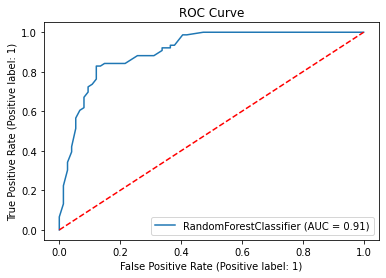

In [332]:

plot = RocCurveDisplay.from_estimator(best_rf, X_test, y_test)
plot.ax_.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), 'r--')
plot.ax_.set_title("ROC Curve")

You can see that our Random Forest has an AUC = 0.91, which is very good. Lastly, we will look at a confusion matrix from the predictions of our model.

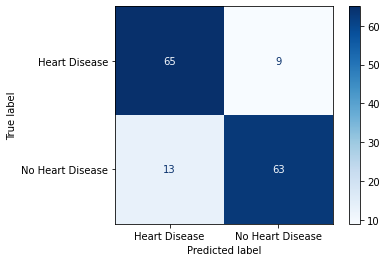

In [333]:
cm = confusion_matrix(y_test, best_rf.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues')

When using our Random Forest to make predictions on the test dataset, we correctly predict that Heart Disease is present 65/74 times. Conversely, we correctly predict that Heart Disease is not present 63/76 times. Overall, these results are pretty good and they showcase the power of our Random Forest. We were able to create a model that can successfully predict the presence of heart disease ~85% of the time on unseen test data.

## Conclusion
As seen in this paper, it is possible to train a model to be able to predict whether or not a patient has heart disease given a handful of simple features. As we saw, the best model for this task was a Random Forest with 50 trees, each with a max depth of 16 and sqrt(n) features. 

### Learning Takeaways
This project was a great chance for me to continue learning and growing as a data scientist. Specifically, I learned how to find my own datasource for a project of interest, how to clean the data, how to transform the data into a usable format, how to conduct EDA, how to test multiple models, and how to summarize the results. As a result of this project, I now feel very comfortable working with supervised learning tasks!

### Potential Errors in Analysis
While this analysis was helpful and successful, there are still a few things that could signify errors in the analysis. Mainly, there is a high chance that there is a bias in our dataset. For example, ~48% of our observations had heart disease. This is much higher than the global rate of people with heart disease. Therefore, we can conclude that our observations are centered around people who are likely or are at risk to have heart disease. As a result of this, it is unclear whether our model could generalize to predicting the presence of heart disease in patients who are not clearly at risk. 

### Further Improvements
One of the joys of Data Science is that there are always ways to improve analyis. One big way that this analysis could be improved is with the testing of Neural Network. The models considered in this study were limited to Logistic Regression, Random Forestes, Boosted Forests, and SVMs. However, a Neural Network could outperform these models and further research should consider a Neural Network. Additionally, data could be collected on more patients to increase the robustness of our model and resulting predictions.


Thanks for reading!